In [1]:
import torch
# import torch as t
# import numpy as np
# import torch.nn as nn
# import torch.optim as optim
# from torchnet import meter
# import xarray as xr
# import rioxarray as rxr
import rasterio

In [2]:
torch.cuda.is_available()

True

In [8]:
src = rasterio.open('data/prcp.tif')
precipitation_data = src.read()

In [9]:
precipitation_data.shape

(183, 600, 1440)

In [11]:
# precipitation_data = rxr.open_rasterio('data/prcp.tif').values

# 将数据转换为 PyTorch 张量
precipitation_data = torch.tensor(precipitation_data, dtype=torch.float32)

precipitation_mean = torch.mean(precipitation_data, 0)
precipitation_std = torch.std(precipitation_data, 0)
precipitation = (precipitation_data - precipitation_mean) / precipitation_std

precipitation_re = precipitation.reshape(183,-1).transpose(0,1)

In [12]:
precipitation_re.shape

torch.Size([864000, 183])

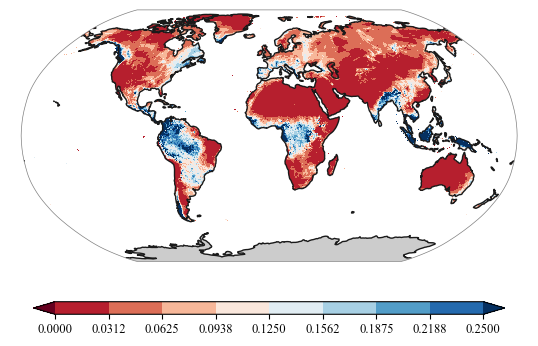

In [28]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
file_name='data/train/prcp.tif'
ds=xr.open_dataset(file_name)
data = ds['band_data'][7]

fig = plt.figure()
proj = ccrs.Robinson() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 0.25, num=9)
plot.one_map_flat(data, ax, levels=levels, cmap="RdBu",  mask_ocean=False, add_coastlines=True, add_land=True,  colorbar=True, plotfunc="pcolormesh")

In [13]:
# 创建二维矩阵
import random
matrix = torch.mean(torch.stack([torch.mean(precipitation_re, 1)], 1), 1).flatten()
# 将矩阵中值为NaN的元素置为0
matrix[torch.isnan(matrix)] = 0

# 获取所有不为NaN的元素的索引
non_negative_indices = torch.nonzero(matrix)
precipitation_re = precipitation_re[non_negative_indices.flatten(), :]

In [14]:
class Config(object):
    t0 = 155 #155
    t1 = 12 
    t = t0 + t1
    train_num = 8000 #8
    validation_num = 1000  #1
    test_num = 1000  #1
    in_channels = 1
    batch_size = 500 #500 NSE 0.75
    lr = .0005 # learning rate
    epochs = 100

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
    
class time_series_decoder_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=120,N=4500,dx=None,dy=None,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.dx = dx
        self.dy = dy
        self.transform = None
    
        
        # time points
        #self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])
        self.x = dx  
        self.fx = dy
        # self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
        #                 A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
        #                 A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
        #                 A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        # add noise
        # self.fx = self.fx + torch.randn(self.fx.shape)
        
        self.masks = self._generate_square_subsequent_mask(t0)
                
        
        # print out shapes to confirm desired output
        print("x: ",self.x.shape,
              "fx: ",self.fx.shape)
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        sample = (self.x[idx,:,:], #self.x[idx,:]
                  self.fx[idx,:],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(Config.t,Config.t)
        for i in range(0,Config.t0):
            mask[i,Config.t0:] = 1 
        for i in range(Config.t0,Config.t):
            mask[i,i+1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
        return mask

In [16]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = context_embedding(Config.in_channels+1,256,5)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
#re     z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z = torch.cat((y,x),1)
        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
#re        z_embedding = self.input_embedding(z).permute(2,0,1)
        z_embedding = self.input_embedding(z).unsqueeze(1).permute(3, 1, 0, 2)
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        x1 = x.type(torch.long)
        x1[x1 < 0] = 0
        positional_embeddings = self.positional_embedding(x1).permute(2, 1, 0, 3)
#re      #positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        input_embedding = z_embedding+positional_embeddings
        input_embedding1 = torch.mean(input_embedding, 1)
        transformer_embedding = self.transformer_decoder(input_embedding1,attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(torch.nn.Module):
    def __init__(self,in_channels=Config.in_channels,embedding_size=256,k=5):
        super(context_embedding,self).__init__()
        self.causal_convolution = CausalConv1d(in_channels,embedding_size,kernel_size=k)

    def forward(self,x):
        x = self.causal_convolution(x)
        return torch.tanh(x)

In [17]:
class LSTM_Time_Series(torch.nn.Module):
    def __init__(self,input_size=2,embedding_size=256,kernel_width=9,hidden_size=512):
        super(LSTM_Time_Series,self).__init__()
        
        self.input_embedding = context_embedding(input_size,embedding_size,kernel_width)    
        
        self.lstm = torch.nn.LSTM(embedding_size,hidden_size,batch_first=True)
        
        self.fc1 = torch.nn.Linear(hidden_size,1)
        
    def forward(self,x,y):
        """
        x: the time covariate
        y: the observed target
        """
        # concatenate observed points and time covariate
        # (B,input size + covariate size,sequence length)
        # z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_obs = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        if isLSTM:
            z_obs = torch.cat((y, x),1)
        # input_embedding returns shape (B,embedding size,sequence length)
        z_obs_embedding = self.input_embedding(z_obs)
        
        # permute axes (B,sequence length, embedding size)
        z_obs_embedding = self.input_embedding(z_obs).permute(0,2,1)
                
        # all hidden states from lstm
        # (B,sequence length,num_directions * hidden size)
        lstm_out,_ = self.lstm(z_obs_embedding)
        
        # input to nn.Linear: (N,*,Hin)
        # output (N,*,Hout)
        return self.fc1(lstm_out)

In [18]:
from torch.utils.data import DataLoader
import random
random.seed(0)

random_indices = random.sample(range(non_negative_indices.shape[0]), Config.train_num)
random_indices1 = random.sample(range(non_negative_indices.shape[0]), Config.validation_num)
random_indices2 = random.sample(range(non_negative_indices.shape[0]), Config.test_num)
dx = torch.stack([torch.cat(Config.train_num*[torch.arange(0,Config.t).type(torch.float).unsqueeze(0)]).cuda()], 1)
dx1 = torch.stack([torch.cat(Config.validation_num*[torch.arange(0,Config.t).type(torch.float).unsqueeze(0)]).cuda()], 1)
dx2 = torch.stack([torch.cat(Config.test_num*[torch.arange(0,Config.t).type(torch.float).unsqueeze(0)]).cuda()], 1)
train_dataset = time_series_decoder_paper(t0=Config.t0,N=Config.train_num,dx=dx ,dy=precipitation_re[np.array([random_indices]).flatten(),0:Config.t].unsqueeze(1))
validation_dataset = time_series_decoder_paper(t0=Config.t0,N=Config.validation_num,dx=dx1,dy=precipitation_re[np.array([random_indices1]).flatten(),0:Config.t].unsqueeze(1))
test_dataset = time_series_decoder_paper(t0=Config.t0,N=Config.test_num,dx=dx2,dy=precipitation_re[np.array([random_indices2]).flatten(),0:Config.t].unsqueeze(1))

x:  torch.Size([8000, 1, 167]) fx:  torch.Size([8000, 1, 167])
x:  torch.Size([1000, 1, 167]) fx:  torch.Size([1000, 1, 167])
x:  torch.Size([1000, 1, 167]) fx:  torch.Size([1000, 1, 167])


In [28]:
a = train_dataset.__getitem__([0])
type(a)
print(a[0].shape, a[1].shape, a[2].shape)

torch.Size([1, 1, 167]) torch.Size([1, 1, 167]) torch.Size([167, 167])


In [11]:
criterion = torch.nn.MSELoss()
train_dl = DataLoader(train_dataset,batch_size=Config.batch_size,shuffle=True, generator=torch.Generator(device='cpu'))
validation_dl = DataLoader(validation_dataset,batch_size=Config.batch_size, generator=torch.Generator(device='cpu'))
test_dl = DataLoader(test_dataset,batch_size=Config.batch_size, generator=torch.Generator(device='cpu'))

In [12]:
criterion_LSTM = torch.nn.MSELoss()

In [13]:
LSTM = LSTM_Time_Series().cuda()

In [14]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator
def train_epoch(LSTM,train_dl,t0=Config.t0):
    LSTM.train()
    train_loss = 0
    n = 0
    for step,(x,y,_) in enumerate(train_dl):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        output = LSTM(x,y)
        
        loss = criterion(output.squeeze()[:,(Config.t0-1):(Config.t0+Config.t1-1)],y.cuda()[:,0,Config.t0:])        
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n
def eval_epoch(LSTM,validation_dl,t0=Config.t0):
    LSTM.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,_) in enumerate(train_dl):
            x = x.cuda()
            y = y.cuda()

            output = LSTM(x,y)
            loss = criterion(output.squeeze()[:,(Config.t0-1):(Config.t0+Config.t1-1)],y.cuda()[:,0,Config.t0:])        
        
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n
def test_epoch(LSTM,test_dl,t0=Config.t0):
    with torch.no_grad():
        predictions = []
        observations = []

        LSTM.eval()
        for step,(x,y,_) in enumerate(train_dl):
            x = x.cuda()
            y = y.cuda()

            output = LSTM(x,y)

            for p,o in zip(output.squeeze()[:,(Config.t0-1):(Config.t0+Config.t1-1)].cpu().numpy().tolist(),y.cuda()[:,0,Config.t0:].cpu().numpy().tolist()):

                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [15]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 30
isLSTM = True
optimizer = torch.optim.Adam(LSTM.parameters(), lr=Config.lr)

for e,epoch in enumerate(range(Config.epochs)):
    train_loss = []
    eval_loss = []
    
    l_train = train_epoch(LSTM,train_dl)
    train_loss.append(l_train)
    
    l_eval = eval_epoch(LSTM,validation_dl)
    eval_loss.append(l_eval)
            
    Rp = test_epoch(LSTM,test_dl)
    
    if Rp_best > Rp:
        Rp_best = Rp

    with torch.no_grad():
        print("Epoch {}: Train loss={} \t Eval loss = {} \t Rp={}".format(e,np.mean(train_loss),np.mean(eval_loss),Rp))
        
        train_epoch_loss.append(np.mean(train_loss))
        eval_epoch_loss.append(np.mean(eval_loss))

Epoch 0: Train loss=1.169178232550621 	 Eval loss = 1.0225972533226013 	 Rp=0.9754564549482763
Epoch 1: Train loss=1.0208212696015835 	 Eval loss = 1.0133976340293884 	 Rp=0.992397172460293
Epoch 2: Train loss=1.0135348699986935 	 Eval loss = 1.0102826319634914 	 Rp=1.0010193148701694
Epoch 3: Train loss=1.0075771994888783 	 Eval loss = 1.003737311810255 	 Rp=0.9874602462009079
Epoch 4: Train loss=0.9986509047448635 	 Eval loss = 0.991193663328886 	 Rp=0.9851476850727866
Epoch 5: Train loss=0.9815127141773701 	 Eval loss = 0.9676672779023647 	 Rp=0.9776791701859356
Epoch 6: Train loss=0.9377330988645554 	 Eval loss = 0.8851083293557167 	 Rp=0.9021427715861259
Epoch 7: Train loss=0.8124373629689217 	 Eval loss = 0.776776347309351 	 Rp=0.8164312307396333
Epoch 8: Train loss=0.7808051072061062 	 Eval loss = 0.7724409475922585 	 Rp=0.8044285279275872
Epoch 9: Train loss=0.7723440378904343 	 Eval loss = 0.7691570967435837 	 Rp=0.8276665115435272
Epoch 10: Train loss=0.7680666074156761 	 Eva

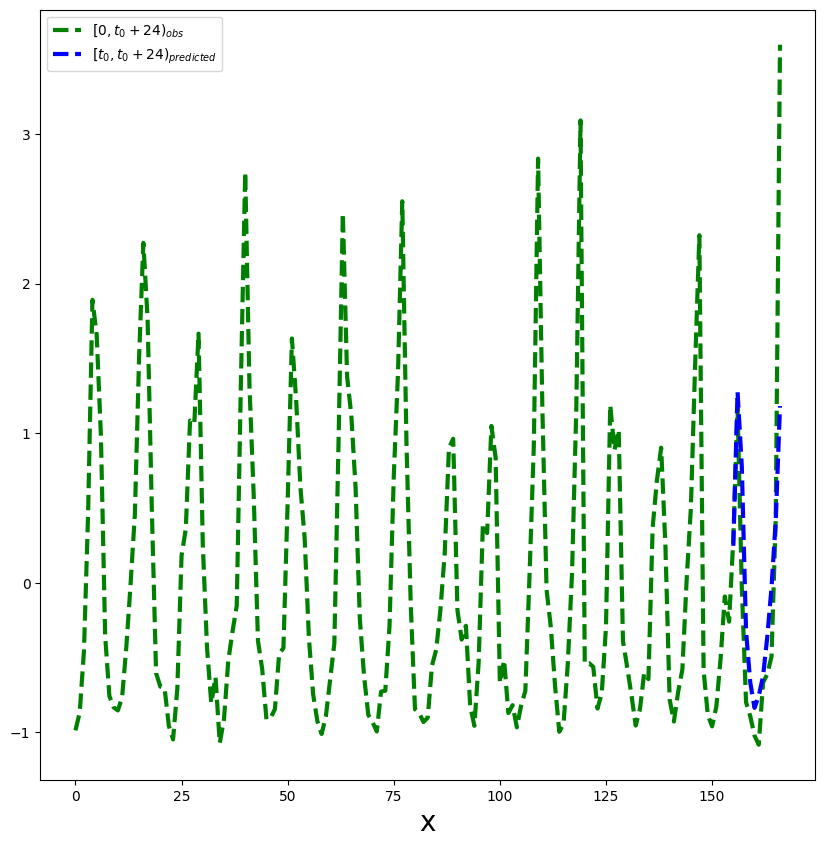

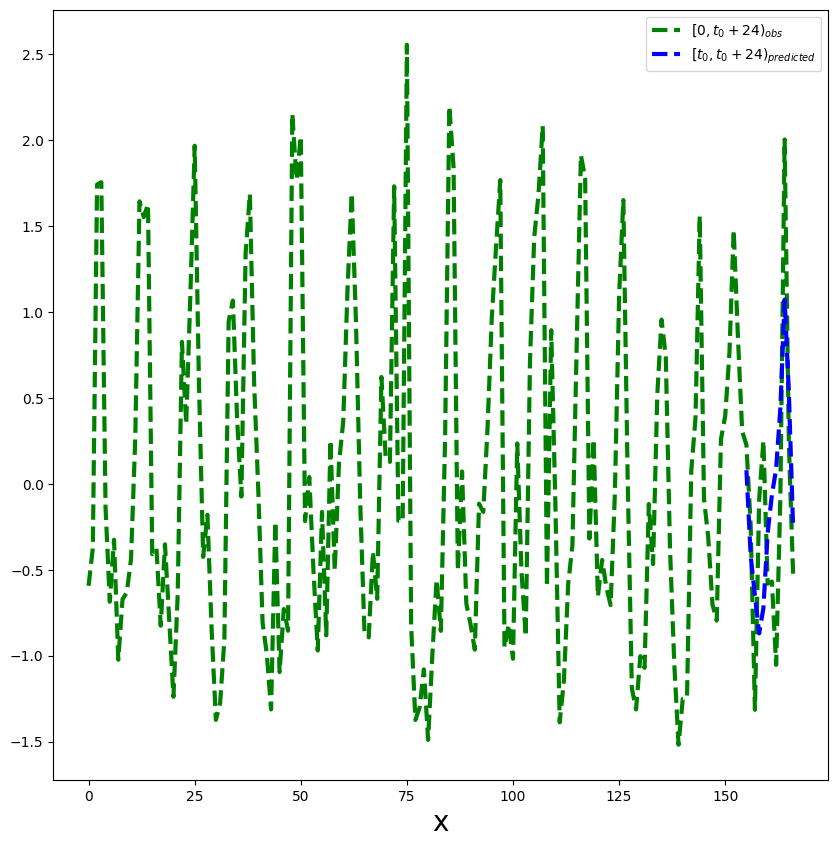

In [16]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
n_plots = 5

t0=120
with torch.no_grad():
    LSTM.eval()
    for step,(x,y,_) in enumerate(test_dl):
        x = x.cuda()
        y = y.cuda()

        output = LSTM(x,y)


        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            plt.plot(x[1, 0].cpu().detach().squeeze().numpy(),y[1].cpu().detach().squeeze().numpy(),'g--',linewidth=3)    
            plt.plot(x[1, 0, Config.t0:].cpu().detach().squeeze().numpy(),output[1,(Config.t0-1):(Config.t0+Config.t1-1),0].cpu().detach().squeeze().numpy(),'b--',linewidth=3)

            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])
            plt.show()

In [17]:
matrix = torch.empty(0).cuda()
obsmat = torch.empty(0).cuda()

with torch.no_grad():
    LSTM.eval()
    predictions = []
    observations = []
    for step,(x,y,attention_masks) in enumerate(test_dl):
        # if step == 8:
        #     break
        output = LSTM(x.cuda(),y.cuda())
        matrix = torch.cat((matrix, output.cuda()))
        obsmat = torch.cat((obsmat, y.cuda()))

pre = matrix.cpu().detach().numpy()
obs = obsmat.cpu().detach().numpy()
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
df = pd.DataFrame({
  'obs': obs[:, 0, Config.t0:Config.t].flatten(),
  'pre': pre[:, Config.t0:Config.t, 0].flatten()
})
df

,obs,pre
0,1.195594,1.645856
1,1.649769,0.247605
2,-0.608017,-0.466307
3,-0.471923,-0.499275
4,-1.097827,-0.693097
...,...,...
11995,3.649456,0.124768
11996,-0.162433,-0.615067
11997,-0.589042,-0.838524
11998,-0.578971,-0.815273


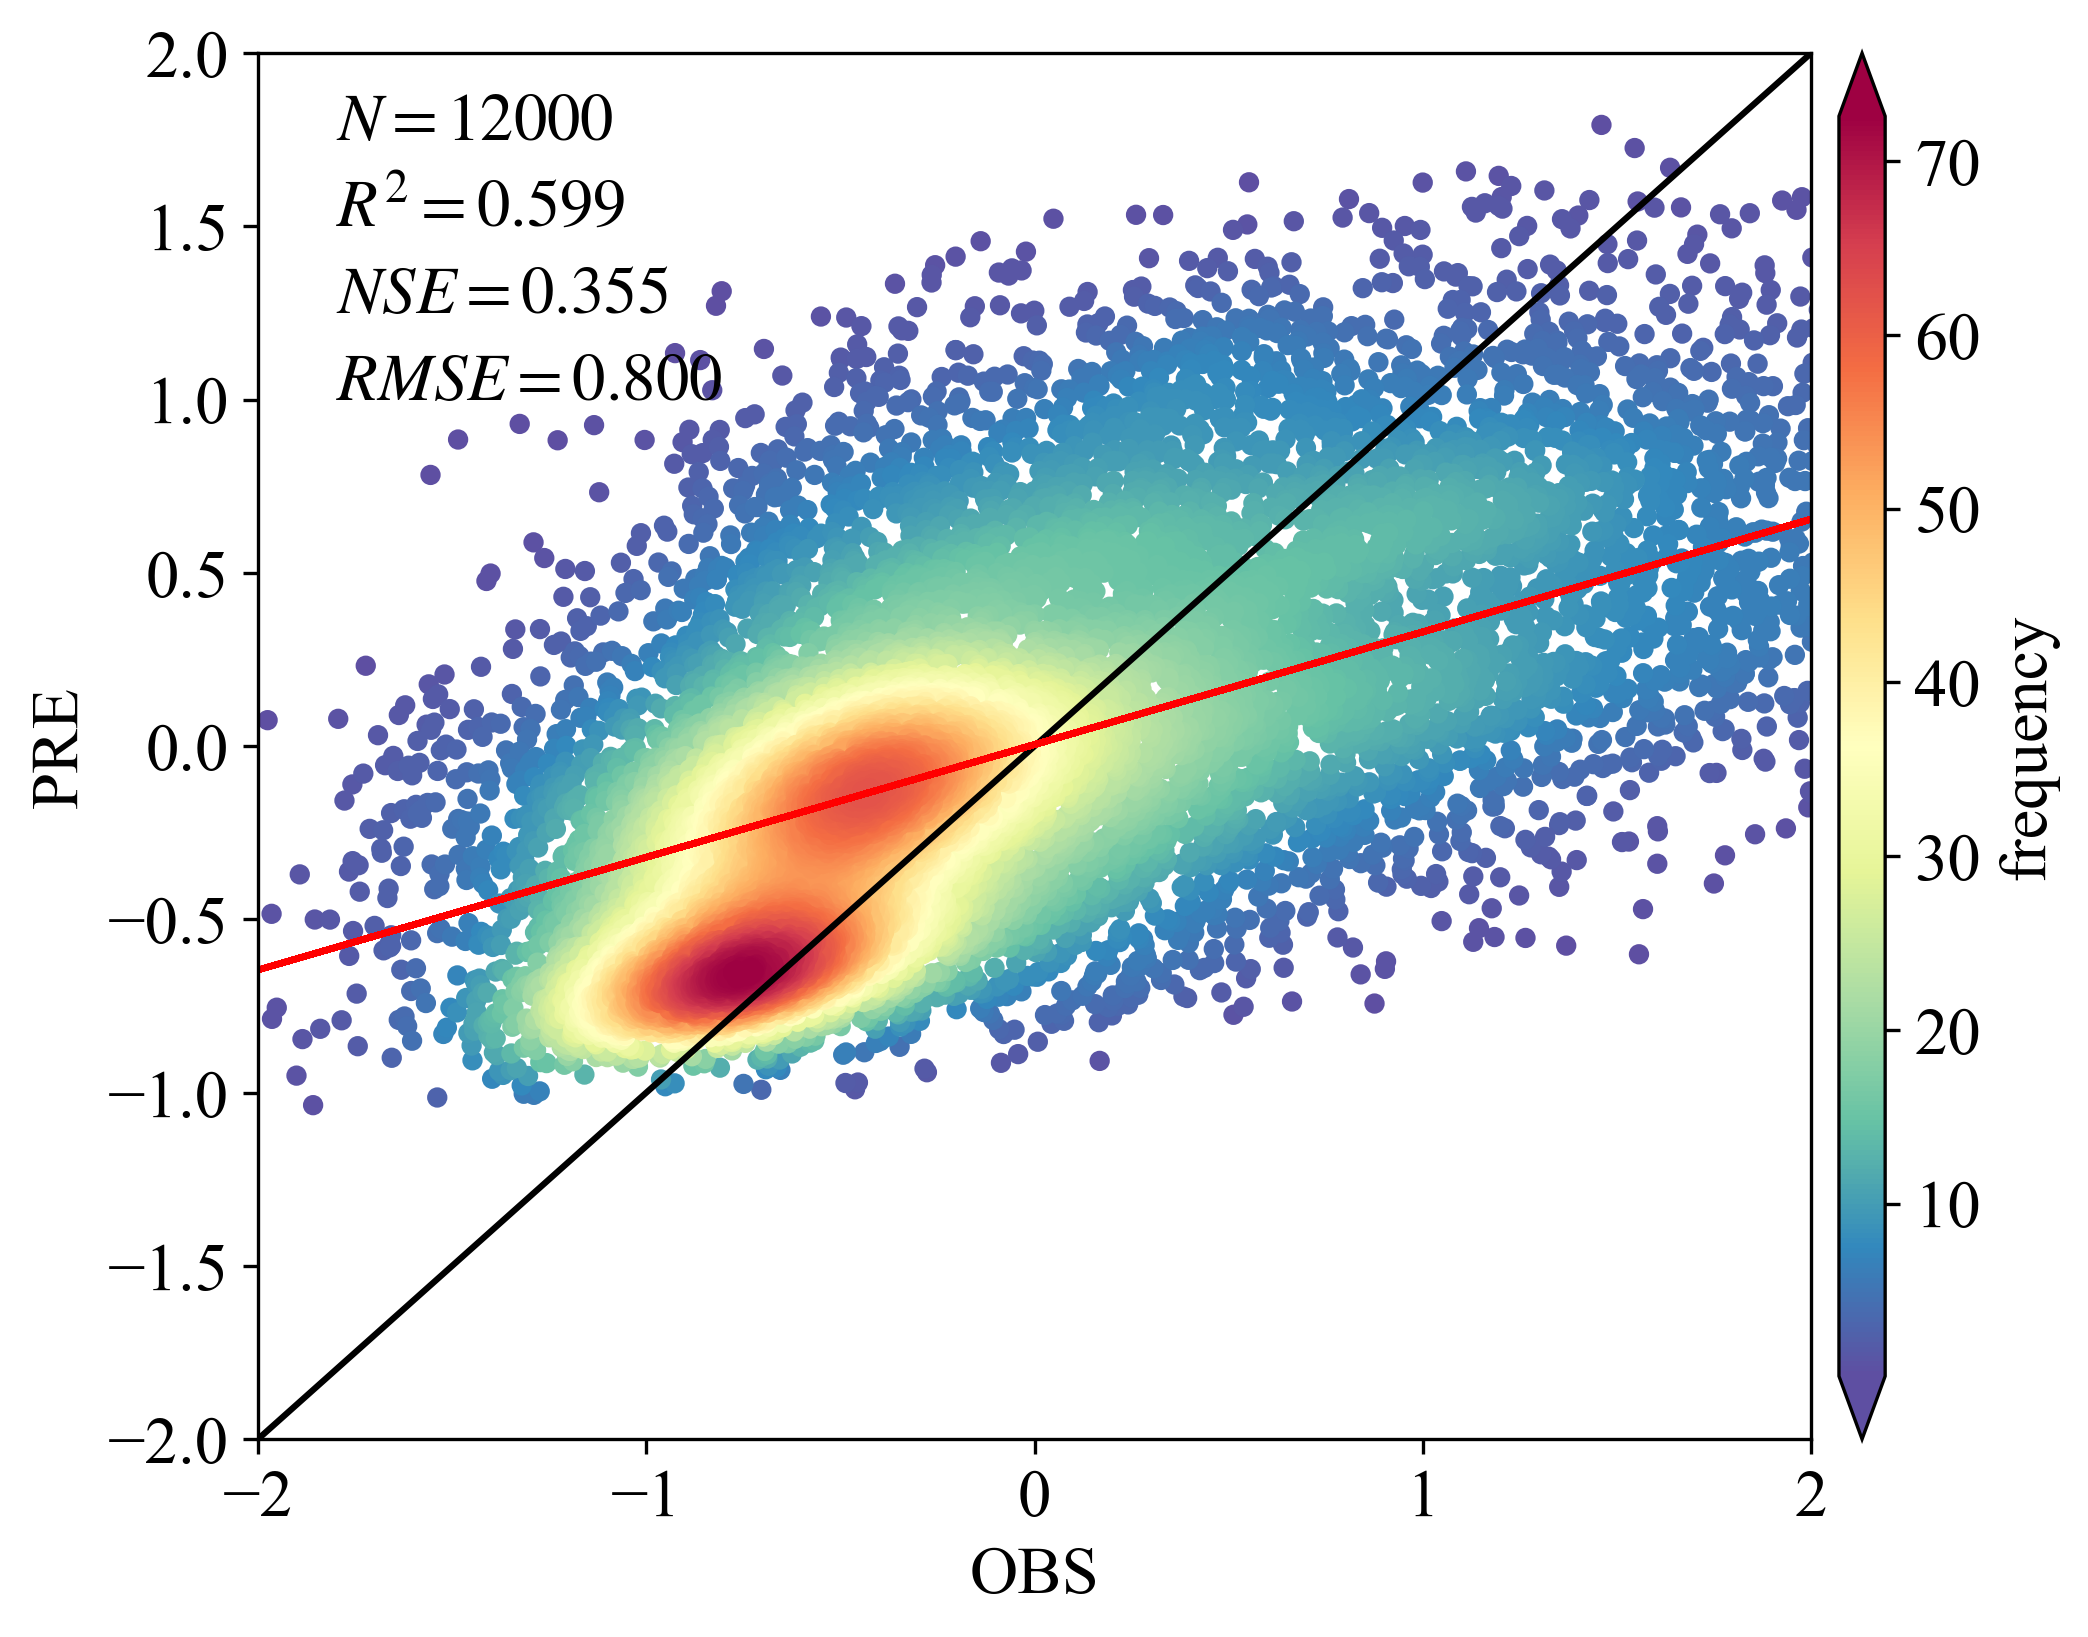

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rcParams
from statistics import mean
from sklearn.metrics import explained_variance_score,r2_score,median_absolute_error,mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
# 加载数据（PS：原始数据太多，采样10000）
# 默认是读取csv/xlsx的列成DataFrame


config = {"font.family":'Times New Roman',"font.size": 16,"mathtext.fontset":'stix'}
#df = df.sample(5000)
# 用于计算指标
x = df['obs']; y = df['pre']
rcParams.update(config)
BIAS = mean(x - y)
MSE = mean_squared_error(x, y)
RMSE = np.power(MSE, 0.5)
R2 = pearsonr(x, y).statistic
adjR2 = 1-((1-r2_score(x,y))*(len(x)-1))/(len(x)-Config.in_channels-1)
MAE = mean_absolute_error(x, y)
EV = explained_variance_score(x, y)
NSE = 1 - (RMSE ** 2 / np.var(x))
# 计算散点密度
xy = np.vstack([x, y])
z = stats.gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x.iloc[idx], y.iloc[idx], z[idx] 

# 拟合（若换MK，自行操作）最小二乘
def slope(xs, ys):
    m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
    b = mean(ys) - m * mean(xs)
    return m, b
k, b = slope(x, y)
regression_line = []
for a in x:
    regression_line.append((k * a) + b)

# 绘图，可自行调整颜色等等
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
scatter=ax.scatter(x, y, marker='o', c=z*100, edgecolors=None ,s=15, label='LST',cmap='Spectral_r')
cbar=plt.colorbar(scatter,shrink=1,orientation='vertical',extend='both',pad=0.015,aspect=30,label='frequency')
plt.plot([-30,30],[-30,30],'black',lw=1.5)  # 画的1:1线，线的颜色为black，线宽为0.8
plt.plot(x,regression_line,'red',lw=1.5)      # 预测与实测数据之间的回归线
plt.axis([-30,30,-30,30])  # 设置线的范围
plt.xlabel('OBS',family = 'Times New Roman')
plt.ylabel('PRE',family = 'Times New Roman')
plt.xticks(fontproperties='Times New Roman')
plt.yticks(fontproperties='Times New Roman')
plt.text(-1.8,1.75, '$N=%.f$' % len(y), family = 'Times New Roman') # text的位置需要根据x,y的大小范围进行调整。
plt.text(-1.8,1.50, '$R^2=%.3f$' % R2, family = 'Times New Roman')
plt.text(-1.8,1.25, '$NSE=%.3f$' % NSE, family = 'Times New Roman')

plt.text(-1.8,1, '$RMSE=%.3f$' % RMSE, family = 'Times New Roman')
plt.xlim(-2,2)                                  # 设置x坐标轴的显示范围
plt.ylim(-2,2)                                  # 设置y坐标轴的显示范围
plt.show()